<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project/07nov2021/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 6.4 MB 9.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 88 kB 4.7 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=98cbb8eae47de460e6afa599656ce5424edc1ce481d4c00c074d89f07272d718

In [2]:
!pip install colorama

In [3]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
import datetime as dt
from sklearn.model_selection import RandomizedSearchCV
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [4]:
def best_param_rf(X_train , y_train , iterations=100):
      


      # Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
      n_estimators = list(range(20, 400, 20))

      # Number of features to consider at every split
      max_features = ['auto', 'sqrt', None, 'log2']

      # Maximum number of levels in tree
      # Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
      max_depth = list(range(5, 50, 10))
      max_depth.append(None)

      # Minimum number of samples required to split a node
      # Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
      min_samples_split = [10, 20, 30, 40]

      # Minimum number of samples required at each leaf node
      min_samples_leaf = [5, 7, 12, 14]

      # Method of selecting samples for training each tree
      bootstrap = [True, False]

      # Create the random grid
      random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf,
                     'bootstrap': bootstrap}

      print(random_grid)

      # New Random Forest Classifier to house optimal parameters
      rf = RandomForestClassifier()

      # Specfiy the details of our Randomized Search
      rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = iterations, cv = 3, verbose=2, random_state=42, n_jobs = -1)

      # Fit the random search model
      rf_random.fit(X_train, y_train)
      dictionary = dict()
      dictionary['Best Score'] = rf_random.best_score_
      dictionary['Best parameters'] = rf_random.best_estimator_.get_params()
      #print(f"Best score: {rf_random.best_score_}")
      #print("Best parameters set:")
      #best_parameters = rf_random.best_estimator_.get_params()
      #for param_name in sorted(random_grid.keys()):
      #  print(f"\t{param_name}: {best_parameters[param_name]}")
      return dictionary

In [5]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
           


In [6]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [7]:
data_for_modeling=yf.download('^nsei',start='2007-01-01',end='2020-12-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [8]:
data_for_modeling['Date']=data_for_modeling['Date'].map(dt.datetime.toordinal)

In [9]:
from numpy.lib.function_base import append
data_for_modeling.ta.macd(fast=45, slow= 30, signal=18, append=True)
data_for_modeling.ta.vortex(length=28,append=True)
data_for_modeling.ta.aroon(length=28,append=True)
data_for_modeling.ta.ema(length=26,append=True)
#data_for_modeling.ta.bbands(append=True)
#data_for_modeling.ta.percent_return(length=28,append=True)
#data_for_modeling.ta.log_return(length=28,append=True)
data_for_modeling.ta.kurtosis(append=True)
data_for_modeling.ta.linreg(length=28,append=True)
data_for_modeling.ta.quantile(append=True)

print()

In [10]:
data_for_modeling.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume',
       'MACD_30_45_18', 'MACDh_30_45_18', 'MACDs_30_45_18', 'VTXP_28',
       'VTXM_28', 'AROOND_28', 'AROONU_28', 'AROONOSC_28', 'EMA_26', 'KURT_30',
       'LR_28', 'QTL_30_0.5'],
      dtype='object')

In [11]:
data_for_modeling['imp']=np.where(data_for_modeling['EMA_26']>data_for_modeling['EMA_26'].shift(1),1,-1)
data_for_modeling['impu']=np.where(data_for_modeling['MACDh_30_45_18']>data_for_modeling['MACDh_30_45_18'].shift(1),1,-1)
data_for_modeling['Impulse']=data_for_modeling['imp']+data_for_modeling['impu']
data_for_modeling['spread']=data_for_modeling['adj_close']-data_for_modeling['LR_28']

In [12]:
#data_for_modeling.rename(columns={'date':'Date'},inplace=True)

In [13]:
features=data_for_modeling.columns.tolist()

In [14]:
features=[feats for feats in features if feats not in ['close','open','low','high','imp','impu']]

In [15]:
data_for_modeling['Signal']=data_for_modeling['close'].transform(lambda x : np.sign(x.diff(30)))


In [16]:
data_for_modeling=data_for_modeling.dropna()

In [17]:
X=data_for_modeling[features]
y=data_for_modeling['Signal']

In [18]:
chk='Timeseries' #Block

In [19]:
from sklearn.model_selection import TimeSeriesSplit

if chk=='Block':
  tscv = BlockingTimeSeriesSplit(n_splits=10)

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
elif chk=='Timeseries':
  tscv = TimeSeriesSplit(n_splits=15)
  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14


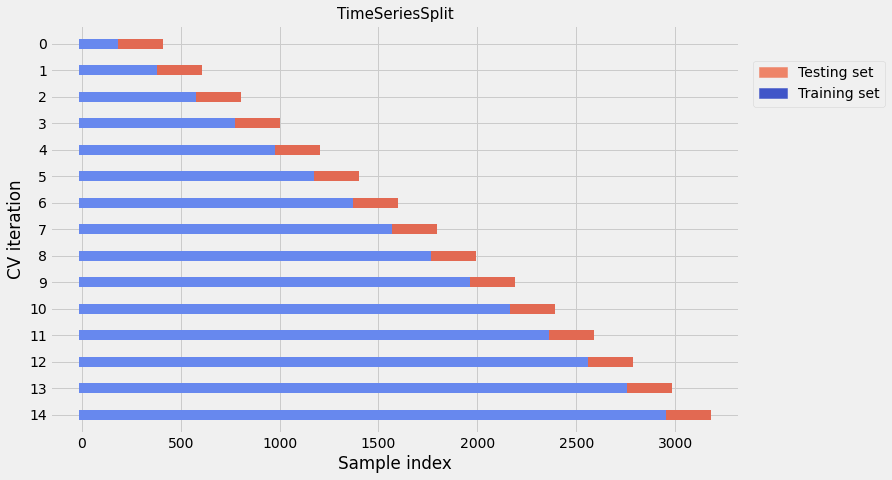

In [20]:
plot_cv_indices(tscv,15, X, y)

In [21]:

for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    


In [22]:
X_train.shape,X_test.shape

((2970, 17), (198, 17))

In [23]:
#best_param_rf(X_train , y_train)

In [24]:
rand_frst_clf = RandomForestClassifier(n_estimators =220,max_depth=35,min_samples_leaf=14,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)

In [25]:

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, min_samples_leaf=14, min_samples_split=40,
                       n_estimators=220, random_state=42)

In [26]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns
feature_imp

VTXP_28           0.270729
VTXM_28           0.229600
AROONOSC_28       0.158322
AROONU_28         0.124452
MACDh_30_45_18    0.064204
MACD_30_45_18     0.044804
AROOND_28         0.040286
MACDs_30_45_18    0.020827
Impulse           0.017657
LR_28             0.005628
adj_close         0.005166
spread            0.004891
date              0.003992
EMA_26            0.003039
KURT_30           0.002596
QTL_30_0.5        0.002477
volume            0.001329
dtype: float64

In [27]:
y_pd= rand_frst_clf.predict(X_train)

In [38]:
y_pd.reshape(-1,1).shape,X_train.shape

((2970, 1), (2970, 17))

In [39]:
np.concatenate((X_train,y_pd.reshape(-1,1)),axis=1)

array([[ 7.33023000e+05,  6.05810010e+03,  0.00000000e+00, ...,
         0.00000000e+00,  1.16527919e+02,  1.00000000e+00],
       [ 7.33024000e+05,  6.04770020e+03,  0.00000000e+00, ...,
         2.00000000e+00,  7.46437529e+01,  1.00000000e+00],
       [ 7.33027000e+05,  5.77700000e+03,  0.00000000e+00, ...,
        -2.00000000e+00, -1.87638337e+02,  1.00000000e+00],
       ...,
       [ 7.37462000e+05,  1.20983496e+04,  4.73500000e+05, ...,
         0.00000000e+00,  4.61792743e+01, -1.00000000e+00],
       [ 7.37465000e+05,  1.20315000e+04,  5.24700000e+05, ...,
         0.00000000e+00, -7.39571120e+00, -1.00000000e+00],
       [ 7.37466000e+05,  1.21079004e+04,  4.80000000e+05, ...,
         2.00000000e+00,  6.51307461e+01, -1.00000000e+00]])

In [ ]:
# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [ ]:
plt.figure(figsize=(10,5))
pd.Series(y_pred).plot();

In [ ]:
plt.figure(figsize=(10,5))
X_test['adj_close'].plot();

In [ ]:
timeseries=pd.concat([X_test['adj_close'].reset_index(),pd.Series(y_pred)],axis=1)

In [ ]:
timeseries.columns=['index','close','prediction']

In [ ]:
timeseries.set_index('index',inplace=True)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'close'], label='close')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'prediction'], label='Nifty')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
data_for_testing=yf.download('^nsei',start='2021-01-01',parse_dates=['Date']).reset_index()

In [ ]:
data_for_testing['Date']=data_for_testing['Date'].map(dt.datetime.toordinal)

In [ ]:
data_for_testing.ta.macd(fast=45, slow= 30, signal=18, append=True)
data_for_testing.ta.vortex(length=28,append=True)
data_for_testing.ta.aroon(length=28,append=True)
data_for_testing.ta.ema(length=26,append=True)
data_for_testing.ta.kurtosis(append=True)
data_for_testing.ta.linreg(length=28,append=True)
data_for_testing.ta.quantile(append=True)
print()

In [ ]:
data_for_testing['imp']=np.where(data_for_testing['EMA_26']>data_for_testing['EMA_26'].shift(1),1,-1)
data_for_testing['impu']=np.where(data_for_testing['MACDh_30_45_18']>data_for_testing['MACDh_30_45_18'].shift(1),1,-1)
data_for_testing['Impulse']=data_for_testing['imp']+data_for_testing['impu']
data_for_testing['spread']=data_for_testing['adj_close']-data_for_testing['LR_28']

In [ ]:
predict=rand_frst_clf.predict(data_for_testing[features].dropna())

In [ ]:
timeseries=pd.concat([data_for_testing['adj_close'].dropna()[-len(predict):].reset_index(),pd.Series(predict)],axis=1)

In [ ]:
timeseries.columns=['index','adj_close','predict']

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),sharex=True)
ax.plot(timeseries.loc[:, :].index, timeseries.loc[:, 'adj_close'], label='Nifty',color='g',marker='o')
ax2=ax.twinx()
ax2.plot(timeseries.loc[:, :].index, timeseries.loc[:, 'predict'], label='Prediction',color='r',linewidth=1)
plt.show()